# Proyecto de futbol en inglaterra

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2

## Equipos con más victorias como local

In [4]:
usuario = 'postgres'
password = 'Mexico03042005'
host = 'localhost'
puerto = '5432'
base_datos = 'futbol'

# Conexión
engine = create_engine(f'postgresql://{usuario}:{password}@{host}:{puerto}/{base_datos}')

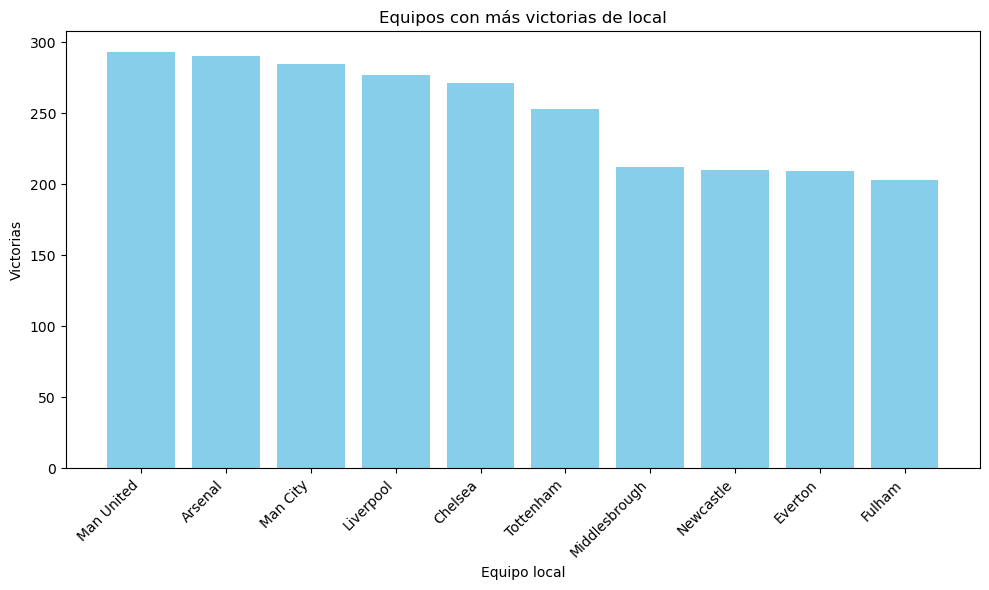

In [5]:
query = """
SELECT home_team, COUNT(*) FILTER (WHERE full_time_result = 'H') AS wins
FROM partido
GROUP BY home_team
ORDER BY wins DESC
LIMIT 10;
"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.bar(df['home_team'], df['wins'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Equipos con más victorias de local")
plt.ylabel("Victorias")
plt.xlabel("Equipo local")
plt.tight_layout()
plt.show()

## Árbitros con más tarjetas amarillas por partido

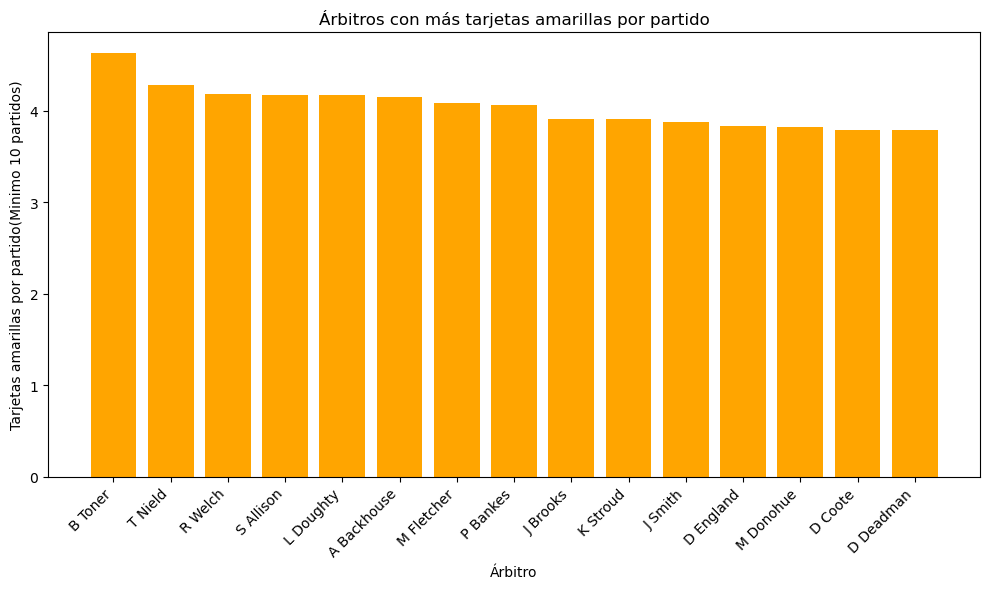

In [6]:
query = """WITH totales AS (
SELECT referee, 
	SUM(home_yellow) + SUM(away_yellow) AS amarillas,
	COUNT(*) AS partidos
FROM partido
GROUP BY referee)
SELECT referee, amarillas::FLOAT/partidos AS amarillas_por_partido
FROM totales
WHERE partidos>10
ORDER BY amarillas_por_partido DESC
LIMIT 15;"""
df = pd.read_sql(query, engine)

plt.figure(figsize=(10, 6))
plt.bar(df['referee'], df['amarillas_por_partido'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title("Árbitros con más tarjetas amarillas por partido")
plt.ylabel("Tarjetas amarillas por partido(Minimo 10 partidos)")
plt.xlabel("Árbitro")
plt.tight_layout()
plt.show()

## Análisis de índice ofensivo y defensivo de cada equipo

In [7]:
query = """
WITH locales AS (
SELECT home_team AS team,
       AVG(full_time_home_goals) AS avg_goals_scored,
       AVG(home_shots) AS avg_shots,
       AVG(home_shots_on_target) AS avg_shots_on_target,
       AVG(home_corners) AS avg_corners,
       AVG(full_time_away_goals) AS avg_goals_conceded,
       AVG(away_shots) AS avg_shots_against,
       AVG(away_shots_on_target) AS avg_shots_on_target_against,
       AVG(away_corners) AS avg_corners_against
FROM partido
GROUP BY home_team),
visitantes AS (
SELECT away_team AS team,
       AVG(full_time_away_goals) AS avg_goals_scored_away,
       AVG(away_shots) AS avg_shots_away,
       AVG(away_shots_on_target) AS avg_shots_on_target_away,
       AVG(away_corners) AS avg_corners_away,
       AVG(full_time_home_goals) AS avg_goals_conceded_away,
       AVG(home_shots) AS avg_shots_against_away,
       AVG(home_shots_on_target) AS avg_shots_on_target_against_away,
       AVG(home_corners) AS avg_corners_against_away
FROM partido
GROUP BY away_team
)
SELECT locales.*, 
	avg_goals_scored_away, 
	avg_shots_away, 
	avg_shots_on_target_away, 
	avg_corners_away, 
	avg_goals_conceded_away, 
	avg_shots_against_away,
	avg_shots_on_target_against_away,
	avg_corners_against_away
FROM locales
JOIN visitantes ON locales.team = visitantes.team;
"""
df = pd.read_sql(query, engine)


In [8]:
df['avg_goals_scored_total'] = (df['avg_goals_scored'] + df['avg_goals_scored_away']) / 2
df['avg_shots_total'] = (df['avg_shots'] + df['avg_shots_away']) / 2
df['avg_shots_on_target_total'] = (df['avg_shots_on_target'] + df['avg_shots_on_target_away']) / 2
df['avg_corners_total'] = (df['avg_corners'] + df['avg_corners_away']) / 2

df['avg_goals_conceded_total'] = (df['avg_goals_conceded'] + df['avg_goals_conceded_away']) / 2
df['avg_shots_against_total'] = (df['avg_shots_against'] + df['avg_shots_against_away']) / 2
df['avg_shots_on_target_against_total'] = (df['avg_shots_on_target_against'] + df['avg_shots_on_target_against_away']) / 2
df['avg_corners_against_total'] = (df['avg_corners_against'] + df['avg_corners_against_away']) / 2


In [9]:
df['attack_index'] = (
    df['avg_goals_scored_total'] * 3 +
    df['avg_shots_on_target_total'] * 2 +
    df['avg_shots_total'] +
    df['avg_corners_total']
)

df['defense_index'] = (
    10 - (
        df['avg_goals_conceded_total'] * 3 +
        df['avg_shots_on_target_against_total'] * 2 +
        df['avg_shots_against_total'] +
        df['avg_corners_against_total']
    )
)

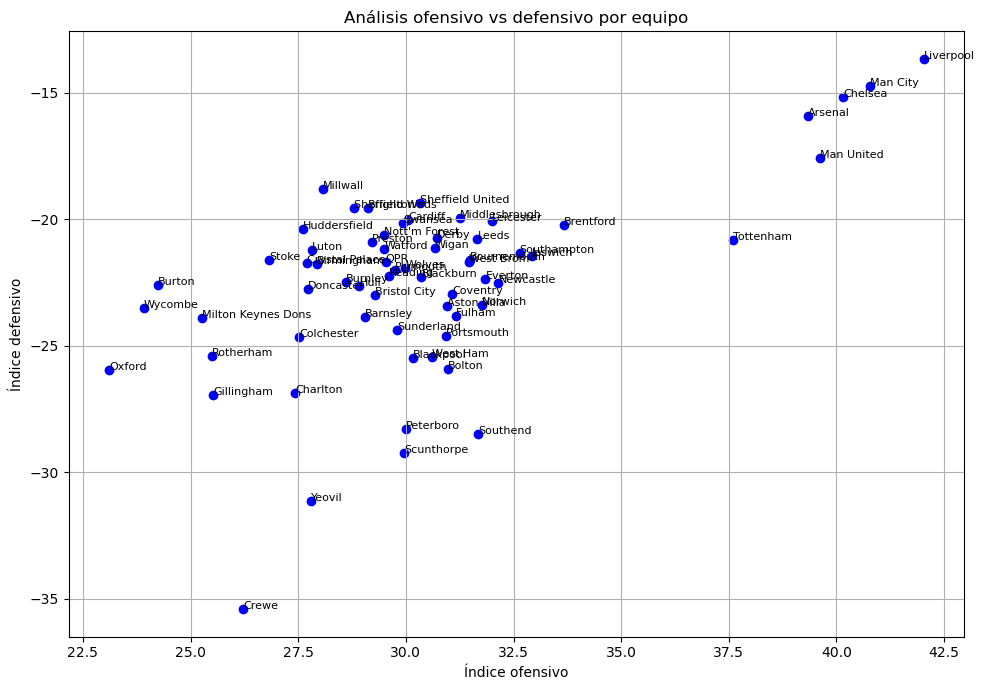

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(df['attack_index'], df['defense_index'], color='blue')

for i, row in df.iterrows():
    plt.text(row['attack_index'], row['defense_index'], row['team'], fontsize=8)

plt.title("Análisis ofensivo vs defensivo por equipo")
plt.xlabel("Índice ofensivo")
plt.ylabel("Índice defensivo")
plt.grid(True)
plt.tight_layout()
plt.show()

## Equipos con mayor diferencia entre índice local y visitante

In [11]:
query = """
WITH locales AS (
SELECT home_team AS team,
       AVG(full_time_home_goals) AS avg_goals_scored,
       AVG(home_shots) AS avg_shots,
       AVG(home_shots_on_target) AS avg_shots_on_target,
       AVG(home_corners) AS avg_corners,
       AVG(full_time_away_goals) AS avg_goals_conceded,
       AVG(away_shots) AS avg_shots_against,
       AVG(away_shots_on_target) AS avg_shots_on_target_against,
       AVG(away_corners) AS avg_corners_against
FROM partido
GROUP BY home_team),
visitantes AS (
SELECT away_team AS team,
       AVG(full_time_away_goals) AS avg_goals_scored_away,
       AVG(away_shots) AS avg_shots_away,
       AVG(away_shots_on_target) AS avg_shots_on_target_away,
       AVG(away_corners) AS avg_corners_away,
       AVG(full_time_home_goals) AS avg_goals_conceded_away,
       AVG(home_shots) AS avg_shots_against_away,
       AVG(home_shots_on_target) AS avg_shots_on_target_against_away,
       AVG(home_corners) AS avg_corners_against_away
FROM partido
GROUP BY away_team
)
SELECT locales.*, 
	avg_goals_scored_away, 
	avg_shots_away, 
	avg_shots_on_target_away, 
	avg_corners_away, 
	avg_goals_conceded_away, 
	avg_shots_against_away,
	avg_shots_on_target_against_away,
	avg_corners_against_away
FROM locales
JOIN visitantes ON locales.team = visitantes.team;
"""
df = pd.read_sql(query, engine)


In [12]:
# Índices ofensivo y defensivo como local
df['attack_index_local'] = (
    df['avg_goals_scored'] * 3 +
    df['avg_shots_on_target'] * 2 +
    df['avg_shots'] +
    df['avg_corners']
)

df['defense_index_local'] = (
    10 - (
        df['avg_goals_conceded'] * 3 +
        df['avg_shots_on_target_against'] * 2 +
        df['avg_shots_against'] +
        df['avg_corners_against']
    )
)

# Índices ofensivo y defensivo como visitante
df['attack_index_away'] = (
    df['avg_goals_scored_away'] * 3 +
    df['avg_shots_on_target_away'] * 2 +
    df['avg_shots_away'] +
    df['avg_corners_away']
)

df['defense_index_away'] = (
    10 - (
        df['avg_goals_conceded_away'] * 3 +
        df['avg_shots_on_target_against_away'] * 2 +
        df['avg_shots_against_away'] +
        df['avg_corners_against_away']
    )
)

In [13]:
# Índice total como local
df['total_index_local'] = df['attack_index_local'] + df['defense_index_local']

# Índice total como visitante
df['total_index_away'] = df['attack_index_away'] + df['defense_index_away']


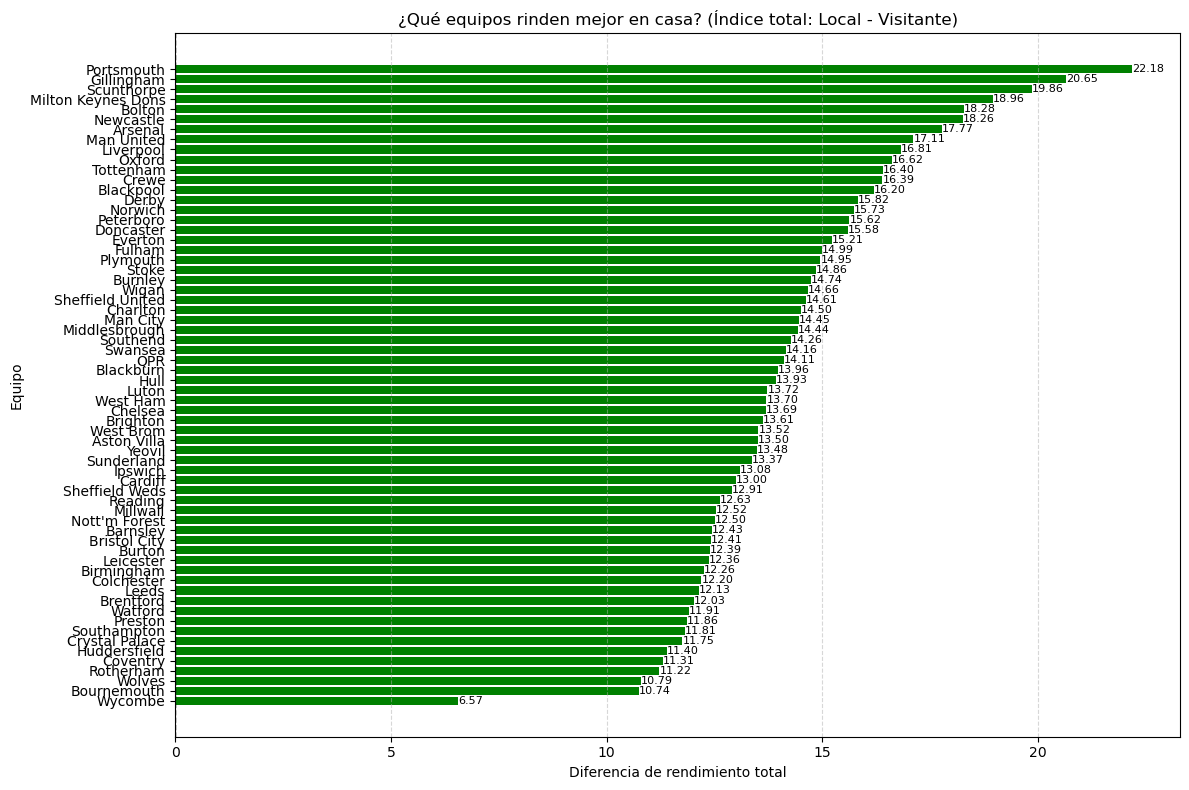

In [14]:
import matplotlib.pyplot as plt
df['total_diff'] = df['total_index_local'] - df['total_index_away']
# Asegúrate de ordenar la diferencia
df_sorted = df.sort_values('total_diff')

plt.figure(figsize=(12, 8))  # más espacio vertical

# Colores distintos para positivos y negativos (opcional)
colors = df_sorted['total_diff'].apply(lambda x: 'green' if x > 0 else 'red')

plt.barh(df_sorted['team'], df_sorted['total_diff'], color=colors)
plt.axvline(0, color='black', linestyle='--', linewidth=1)

plt.title("¿Qué equipos rinden mejor en casa? (Índice total: Local - Visitante)")
plt.xlabel("Diferencia de rendimiento total")
plt.ylabel("Equipo")

# Mejor separación de nombres
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Opcional: añadir valores al lado de cada barra
for index, value in enumerate(df_sorted['total_diff']):
    plt.text(value, index, f"{value:.2f}", va='center',
             ha='left' if value > 0 else 'right', fontsize=8, color='black')

plt.show()




## Partidos ganados x -- SQL

In [21]:

consulta = '''WITH partidos AS (
  SELECT 
    date,
    home_team AS team,
    away_team AS opponent,
    full_time_home_goals AS goals_for,
    full_time_away_goals AS goals_against,
    home_shots AS shots,
    home_shots_on_target AS shots_on_target,
    home_corners AS corners,
    -- Puntos: 1 si gana, 0.5 si empata, 0 si pierde
    CASE 
      WHEN full_time_result = 'H' THEN 1
      WHEN full_time_result = 'D' THEN 0.5
      ELSE 0
    END AS won,
    CASE 
      WHEN home_shots_on_target > away_shots_on_target AND home_corners > away_corners THEN 0.9  
      WHEN home_shots > away_shots THEN 0.8  
      WHEN home_shots_on_target > away_shots_on_target THEN 0.7  
      ELSE 0.5  
    END AS expected_win
  FROM partido

  UNION ALL

  SELECT 
    date,
    away_team AS team,
    home_team AS opponent,
    full_time_away_goals AS goals_for,
    full_time_home_goals AS goals_against,
    away_shots AS shots,
    away_shots_on_target AS shots_on_target,
    away_corners AS corners,
    CASE 
      WHEN full_time_result = 'A' THEN 1
      WHEN full_time_result = 'D' THEN 0.5
      ELSE 0
    END AS won,
    CASE 
      WHEN away_shots_on_target > home_shots_on_target AND away_corners > home_corners THEN 0.8  
      WHEN away_shots > home_shots THEN 0.7  
      WHEN away_shots_on_target > home_shots_on_target THEN 0.6  
      ELSE 0.0  
    END AS expected_win
  FROM partido
)

SELECT 
  team,
  COUNT(*) AS matches,
  ROUND(SUM(won), 2) AS real_points,
  ROUND(SUM(expected_win), 2) AS expected_points,
  ROUND(SUM(won) - SUM(expected_win), 2) AS overperformance
FROM partidos
GROUP BY team
ORDER BY overperformance DESC;

 '''


/var/folders/mk/354ykzvd4xb9dv44bwrmk9w80000gn/T/ipykernel_13224/2896607425.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='overperformance', y='team', data=df.sort_values('overperformance'), palette='viridis')


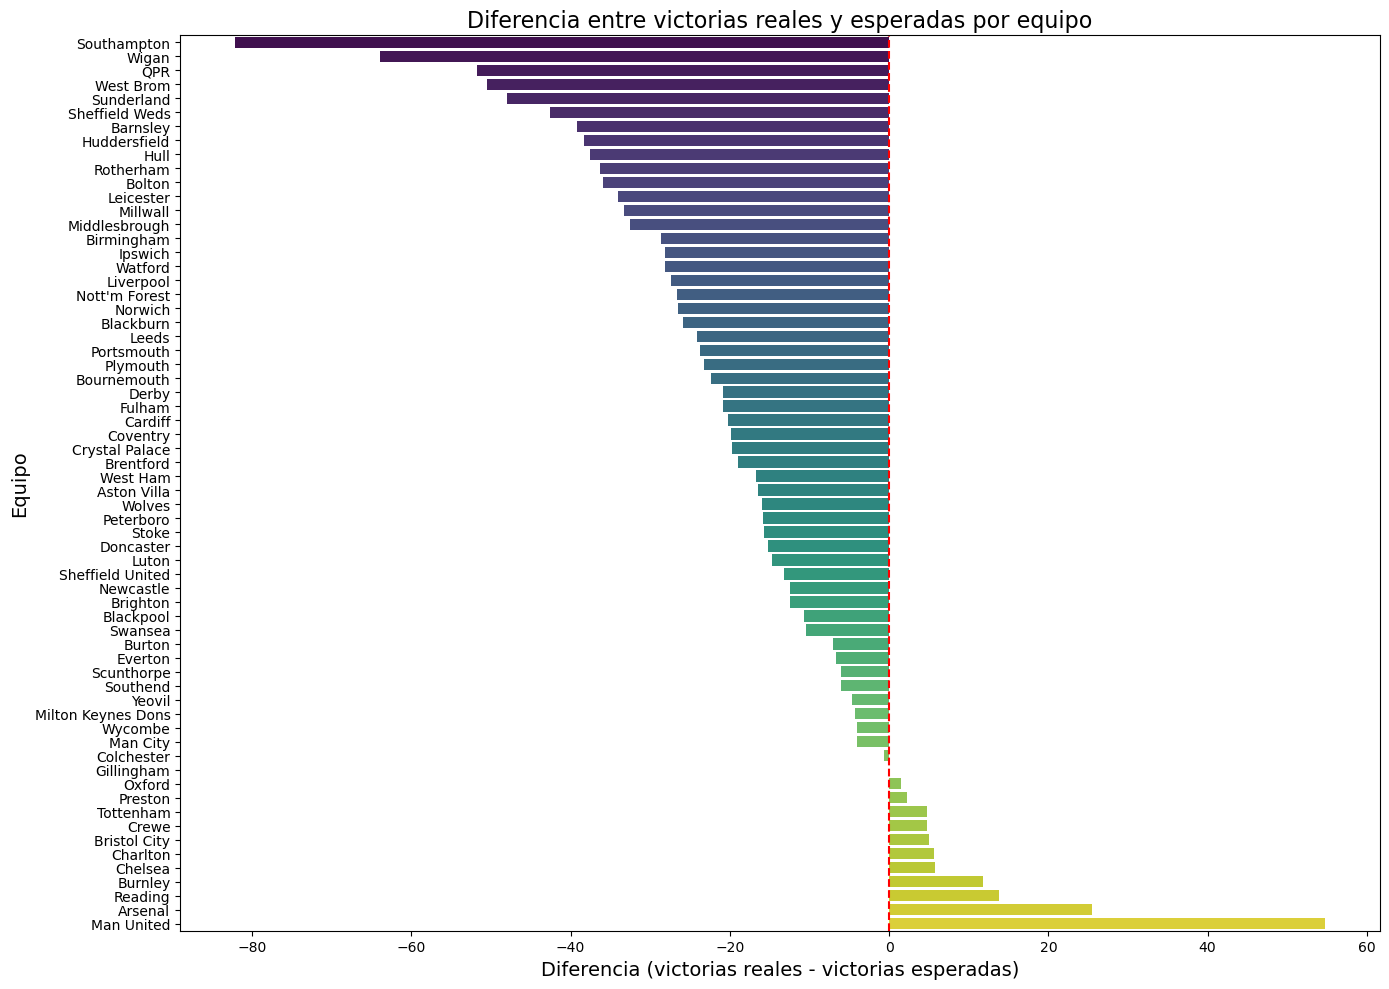

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Consulta SQL (asegúrate de ejecutarla y obtener el DataFrame)
df = pd.read_sql(consulta, engine)

# Gráfico de barras más grande
plt.figure(figsize=(14, 10))  # Aumento de tamaño de la figura

# Barra con mayor contraste de colores
sns.barplot(x='overperformance', y='team', data=df.sort_values('overperformance'), palette='viridis')

# Línea para señalar la diferencia cero
plt.axvline(0, color='red', linestyle='--')

# Título y etiquetas mejoradas
plt.title("Diferencia entre victorias reales y esperadas por equipo", fontsize=16)
plt.xlabel("Diferencia (victorias reales - victorias esperadas)", fontsize=14)
plt.ylabel("Equipo", fontsize=14)

# Ajuste para mayor visibilidad
plt.tight_layout()

# Mostrar la gráfica
plt.show()

